# Logistic Regression
Implementation of logistic regression for binary class.

### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
%matplotlib inline

### Dataset

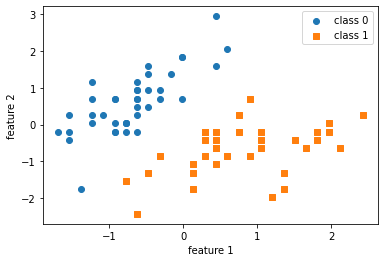

In [2]:
data_source = np.lib.DataSource()
data = data_source.open('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')


x = np.genfromtxt(BytesIO(data.read().encode()), delimiter=',', usecols=range(2), max_rows=100)
y = np.zeros(100)
y[50:] = 1


np.random.seed(1)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std


plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

### Model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class LogisticRegression(torch.nn.Module):
    
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # change random weigths to zero
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
    
    def forward(self, x):
        netinputs = self.linear(x)
        output = torch.sigmoid(netinputs)
        return output 

### Train


In [4]:
model = LogisticRegression(num_features=2).to(device)
cost_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


def comp_accuracy(label_var, pred_probas):
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc


for epoch in range(10):
    
    # Compute outputs 
    out = model(X_train_tensor)
    
    # Compute gradients
    loss = cost_fn(out, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print('Train Accuracy: %.3f' % acc, end="")
    print('Cost: %.3f' % cost_fn(pred_probas, y_train_tensor))
    
    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)

Epoch: 001Train Accuracy: 0.987Cost: 2.939
Epoch: 002Train Accuracy: 0.987Cost: 2.397
Epoch: 003Train Accuracy: 0.987Cost: 2.060
Epoch: 004Train Accuracy: 1.000Cost: 1.823
Epoch: 005Train Accuracy: 1.000Cost: 1.645
Epoch: 006Train Accuracy: 1.000Cost: 1.505
Epoch: 007Train Accuracy: 1.000Cost: 1.391
Epoch: 008Train Accuracy: 1.000Cost: 1.297
Epoch: 009Train Accuracy: 1.000Cost: 1.218
Epoch: 010Train Accuracy: 1.000Cost: 1.149

Model parameters:
  Weights: Parameter containing:
tensor([[ 2.4825, -1.7823]], requires_grad=True)
  Bias: Parameter containing:
tensor([0.0599], requires_grad=True)


### Test

In [5]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)


pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)


print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%
